In [37]:
# importing the dependencies
import sys
import numpy as np
# np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.resnet50 import ResNet50
import keras
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten 
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint, EarlyStopping,ModelCheckpoint
from keras.models import Sequential,Model,load_model
from keras.optimizers import SGD, Adam
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
# Normalize image vectors
X_train = X_train/255.
X_test = X_test/255.

In [5]:
X_train_md = X_train
X1 = []
for i in X_train_md:
    tmp = np.zeros((4,28))

    i = np.vstack((i,tmp))

    tmp = np.zeros((32,4))
    i = np.hstack((i, tmp))
    X1.append(i)
    
X_test_md = X_test
X2 = []
for i in X_test_md:
    tmp = np.zeros((4,28))

    i = np.vstack((i,tmp))

    tmp = np.zeros((32,4))
    i = np.hstack((i, tmp))
    X2.append(i)

In [ ]:
X1 = np.array(X1)
X2 = np.array(X2)
X1.shape
X_train_fn = X1
X_test_fn = X2
x_train_fn[0].shape

In [22]:
X_train_stacked = np.stack((X_train_fn,)*3, axis=-1)

X_test_stacked = np.stack((X_test_fn,)*3, axis=-1)

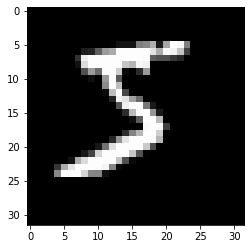

In [24]:
plt.imshow(np.array(X_train_stacked[0]))
plt.show()

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train_stacked, Y_train, test_size=10000)

In [42]:
X_test = X_test_stacked

In [28]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [44]:
# Convert training and test labels to one hot matrices
# Y_train = convert_to_one_hot(Y_train, 10).T
# Y_test = convert_to_one_hot(Y_test, 10).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_val shape: (10000, 32, 32, 3)
Y_val shape: (10000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


In [31]:
Y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [32]:
# Get a ResNet50 model
def resnet50_model(classes=10, *args, **kwargs):
    # Load a model if we have saved one
    if(os.path.isfile('C:\\DATA\\Python-data\\CIFAR-10\\models\\resnet_50.h5') == True):
        return keras.models.load_model('C:\\DATA\\Python-data\\CIFAR-10\\models\\resnet_50.h5')
    # Create an input layer 
    input = keras.layers.Input(shape=(None, None, 3))
    # Create output layers
    output = keras.layers.ZeroPadding2D(padding=3, name='padding_conv1')(input)
    output = keras.layers.Conv2D(64, (7, 7), strides=(2, 2), use_bias=False, name='conv1')(output)
    output = keras.layers.BatchNormalization(axis=3, epsilon=1e-5, name='bn_conv1')(output)
    output = keras.layers.Activation('relu', name='conv1_relu')(output)
    output = keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(output)
    output = conv_block(output, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    output = identity_block(output, 3, [64, 64, 256], stage=2, block='b')
    output = identity_block(output, 3, [64, 64, 256], stage=2, block='c')
    output = conv_block(output, 3, [128, 128, 512], stage=3, block='a')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='b')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='c')
    output = identity_block(output, 3, [128, 128, 512], stage=3, block='d')
    output = conv_block(output, 3, [256, 256, 1024], stage=4, block='a')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='b')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='c')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='d')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='e')
    output = identity_block(output, 3, [256, 256, 1024], stage=4, block='f')
    output = conv_block(output, 3, [512, 512, 2048], stage=5, block='a')
    output = identity_block(output, 3, [512, 512, 2048], stage=5, block='b')
    output = identity_block(output, 3, [512, 512, 2048], stage=5, block='c')
    output = keras.layers.GlobalAveragePooling2D(name='pool5')(output)
    output = keras.layers.Dense(classes, activation='softmax', name='fc1000')(output)
    # Create a model from input layer and output layers
    model = keras.models.Model(inputs=input, outputs=output, *args, **kwargs)
    # Print model
    print()
    print(model.summary(), '\n')
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01, clipnorm=0.001), metrics=['accuracy'])
    # Return a model
    return model

In [33]:
# Create an identity block
def identity_block(input, kernel_size, filters, stage, block):
    
    # Variables
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Create layers
    output = keras.layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(output)
    output = keras.layers.add([output, input])
    output = keras.layers.Activation('relu')(output)
    # Return a block
    return output

In [34]:
# Create a convolution block
def conv_block(input, kernel_size, filters, stage, block, strides=(2, 2)):
    # Variables
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    # Create block layers
    output = keras.layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2a')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters2, kernel_size, padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(output)
    output = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(output)
    shortcut = keras.layers.Conv2D(filters3, (1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input)
    shortcut = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '1')(shortcut)
    output = keras.layers.add([output, shortcut])
    output = keras.layers.Activation('relu')(output)
    # Return a block
    return output


In [45]:
# Train a model
def train():
    # Variables, 0 epochs so far
    epochs = 1
    batch_size = 64
    train_samples = 10 * 6000 # 10 categories with 5000 images in each category
    validation_samples = 10 * 1000 # 10 categories with 1000 images in each category
    img_width, img_height = 32, 32
    # Get the model (10 categories)
    model = resnet50_model(10)
    
    # Start training, fit the model
    model.fit( 
        X_train,  
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val))
    # Save model to disk
    model.save('resnet.h5')
    print('Saved model to disk!')


In [46]:
# Train a model
train()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 padding_conv1 (ZeroPadding2D)  (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9408        ['padding_conv1[0][0]']          
                                64)                                                        

                                                                                                  
 activation_53 (Activation)     (None, None, None,   0           ['add_17[0][0]']                 
                                256)                                                              
                                                                                                  
 res2c_branch2a (Conv2D)        (None, None, None,   16448       ['activation_53[0][0]']          
                                64)                                                               
                                                                                                  
 bn2c_branch2a (BatchNormalizat  (None, None, None,   256        ['res2c_branch2a[0][0]']         
 ion)                           64)                                                               
                                                                                                  
 activatio

 ion)                           128)                                                              
                                                                                                  
 activation_61 (Activation)     (None, None, None,   0           ['bn3b_branch2b[0][0]']          
                                128)                                                              
                                                                                                  
 res3b_branch2c (Conv2D)        (None, None, None,   66048       ['activation_61[0][0]']          
                                512)                                                              
                                                                                                  
 bn3b_branch2c (BatchNormalizat  (None, None, None,   2048       ['res3b_branch2c[0][0]']         
 ion)                           512)                                                              
          

 activation_69 (Activation)     (None, None, None,   0           ['bn4a_branch2a[0][0]']          
                                256)                                                              
                                                                                                  
 res4a_branch2b (Conv2D)        (None, None, None,   590080      ['activation_69[0][0]']          
                                256)                                                              
                                                                                                  
 bn4a_branch2b (BatchNormalizat  (None, None, None,   1024       ['res4a_branch2b[0][0]']         
 ion)                           256)                                                              
                                                                                                  
 activation_70 (Activation)     (None, None, None,   0           ['bn4a_branch2b[0][0]']          
          

                                                                                                  
 add_25 (Add)                   (None, None, None,   0           ['bn4c_branch2c[0][0]',          
                                1024)                             'activation_74[0][0]']          
                                                                                                  
 activation_77 (Activation)     (None, None, None,   0           ['add_25[0][0]']                 
                                1024)                                                             
                                                                                                  
 res4d_branch2a (Conv2D)        (None, None, None,   262400      ['activation_77[0][0]']          
                                256)                                                              
                                                                                                  
 bn4d_bran

                                256)                                                              
                                                                                                  
 res4f_branch2c (Conv2D)        (None, None, None,   263168      ['activation_85[0][0]']          
                                1024)                                                             
                                                                                                  
 bn4f_branch2c (BatchNormalizat  (None, None, None,   4096       ['res4f_branch2c[0][0]']         
 ion)                           1024)                                                             
                                                                                                  
 add_28 (Add)                   (None, None, None,   0           ['bn4f_branch2c[0][0]',          
                                1024)                             'activation_83[0][0]']          
          

 bn5c_branch2a (BatchNormalizat  (None, None, None,   2048       ['res5c_branch2a[0][0]']         
 ion)                           512)                                                              
                                                                                                  
 activation_93 (Activation)     (None, None, None,   0           ['bn5c_branch2a[0][0]']          
                                512)                                                              
                                                                                                  
 res5c_branch2b (Conv2D)        (None, None, None,   2359808     ['activation_93[0][0]']          
                                512)                                                              
                                                                                                  
 bn5c_branch2b (BatchNormalizat  (None, None, None,   2048       ['res5c_branch2b[0][0]']         
 ion)     

In [47]:
res_model = load_model("resnet.h5")

In [49]:
loss, accuracy = res_model.evaluate(X_test, Y_test)

print(accuracy)

313/313 [==============================] - 39s 117ms/step - loss: 1.0544 - accuracy: 0.9138
0.9138000011444092


Enter the path to image MNIST_digit.png


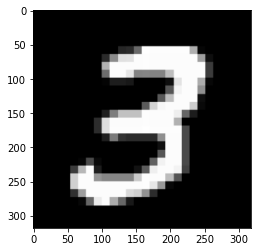

(1, 32, 32, 3)


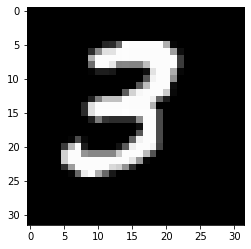

1/1 [==============================] - 0s 51ms/step
The Handwritten Digit is recognized as :  3


In [85]:
# The Predictive Ststem

# image acquisition
input_image_path = input('Enter the path to image ') # test_input.png

input_image = cv2.imread(input_image_path, 0)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.show()


# preprocessing
input_image = input_image / 255 
input_image = cv2.resize(input_image, (28,28))

tmp = np.zeros((4,28))
input_image = np.vstack((input_image,tmp))
tmp = np.zeros((32,4))
input_image_resized = np.hstack((input_image, tmp))

input_image_reshaped = np.stack((input_image_resized, )*3, axis=2)
input_image_reshaped = np.expand_dims(input_image_reshaped, 0)
print(input_image_reshaped.shape)

plt.imshow(input_image_reshaped[0])
plt.show()

# prediction
input_prediction = res_model.predict(input_image_reshaped)
print('The Handwritten Digit is recognized as : ', np.argmax(input_prediction))